In [1]:
import pandas as pd
import numpy as np
import keras
from keras.utils.data_utils import get_file
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from os.path import join
import multiprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import keras.backend.tensorflow_backend as K
from jointbayesian import jointbayesian

%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_HOME = '../lfw-aligned-with-32-margin-resized/'

In [3]:
PAIRS_PATH = '../pairs.txt'

In [4]:
raw_dataset = pd.read_csv(PAIRS_PATH, nrows=None)
raw_dataset.columns = ['data']

In [5]:
raw_dataset.shape

(6000, 1)

In [6]:
def split_raw_data(row):
    fields = str(row[0]).split('\t')
    is_the_same = 0
    path1, path2 = '{}/{}_{:04d}.png', '{}/{}_{:04d}.png'
    if len(fields) == 3:
        is_the_same = 1
        path1 = path1.format(fields[0], fields[0], int(fields[1]))
        path2 = path2.format(fields[0], fields[0], int(fields[2]))
    elif len(fields) == 4:
        path1 = path1.format(fields[0], fields[0], int(fields[1]))
        path2 = path2.format(fields[2], fields[2], int(fields[3]))
    else:
        raise(Exception('invalid fields'))
    
    return pd.Series([path1, path2, is_the_same], ['path1', 'path2', 'is_the_same']) 

In [7]:
dataset = raw_dataset.apply(split_raw_data, axis=1)

In [8]:
dataset.head()

,path1,path2,is_the_same
0,Abel_Pacheco/Abel_Pacheco_0001.png,Abel_Pacheco/Abel_Pacheco_0004.png,1
1,Akhmed_Zakayev/Akhmed_Zakayev_0001.png,Akhmed_Zakayev/Akhmed_Zakayev_0003.png,1
2,Akhmed_Zakayev/Akhmed_Zakayev_0002.png,Akhmed_Zakayev/Akhmed_Zakayev_0003.png,1
3,Amber_Tamblyn/Amber_Tamblyn_0001.png,Amber_Tamblyn/Amber_Tamblyn_0002.png,1
4,Anders_Fogh_Rasmussen/Anders_Fogh_Rasmussen_00...,Anders_Fogh_Rasmussen/Anders_Fogh_Rasmussen_00...,1


In [9]:
dataset.shape

(6000, 3)

In [10]:
from PIL import Image

def path2ImgVec(path):
    x = img_to_array(load_img(join(DATA_HOME, path)))
#     x = img_to_array(load_img(join(DATA_HOME, path)).convert('L'))
    return x.reshape((1,) + x.shape)

def path2ImgVecFlipped(path):
    img = load_img(join(DATA_HOME, path))
#     img = load_img(join(DATA_HOME, path)).convert('L')
    img = img.transpose(Image.FLIP_LEFT_RIGHT)
    x = img_to_array(img)
    return x.reshape((1,) + x.shape)

In [11]:
img_paths = list(set(dataset.path1.tolist()+dataset.path2.tolist()))
len(img_paths)

7701

In [12]:
pool = multiprocessing.Pool(8)
results1 = pool.map(path2ImgVec, img_paths)
pool.close()
pool.join()

In [13]:
pool = multiprocessing.Pool(8)
results2 = pool.map(path2ImgVecFlipped, img_paths)
pool.close()
pool.join()

In [14]:
img_vecs1 = np.vstack(results1)
img_vecs1.shape
img_vecs2 = np.vstack(results2)
img_vecs2.shape

(7701, 55, 47, 3)

In [15]:
input_shape = img_vecs1.shape[1:]
img_vecs1.shape

(7701, 55, 47, 3)

In [16]:
from keras.models import load_model

model = load_model('../models/webface-full-simple-cnn.A.aligned.margin32.s20.model.h5')

In [17]:
from keras import backend as K
inp = model.input

outputs = [model.layers[-2].output]
functor = K.function([inp] + [K.learning_phase()], outputs)

In [18]:
img_vecs1.shape

(7701, 55, 47, 3)

In [19]:
deepids1 = functor([img_vecs1, 1.])[0]
deepids2 = functor([img_vecs2, 1.])[0]
deepids1.shape

(7701, 160)

In [20]:
img_paths_flipped = ["~"+i for i in img_paths]

In [21]:
deepids = np.vstack([deepids1, deepids2])

In [22]:
deepids.shape

(15402, 160)

In [23]:
import pickle

model_file = '../models/joint-bayes-model.pkl'
A, G, mean_value = None, None, None
with open(model_file, 'rb') as f:
    A = pickle.load(f)
    G = pickle.load(f)
    mean_value = pickle.load(f)
    print('Load model from', model_file)

Load model from ../models/joint-bayes-model.pkl


In [24]:
mean_value.shape

(160,)

In [25]:
deepids -= mean_value

In [26]:
img_deepid_mem = {k:v for k, v in zip(img_paths+img_paths_flipped, deepids)}

In [27]:
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis
from scipy.stats import skew, kurtosis, tvar, entropy, pearsonr

COL_NAMES = [
#     "z_cosine1",
#     "z_cosine2",
#     "z_cosine3",
#     "z_cosine4",

#     'z_skew1',
#     'z_skew2',
#     'z_kurtosis1',
#     'z_kurtosis2',
#     'z_tvar1',
#     'z_tvar2',
    'z_bayes1',
    'z_bayes2',
    'z_bayes3',
    'z_bayes4',
] + ['is_the_same']

def to_deepid_features(row):
    vec1 = img_deepid_mem[row['path1']]
    vec2 = img_deepid_mem[row['path2']]

    fvec1 = img_deepid_mem["~"+row['path1']]
    fvec2 = img_deepid_mem["~"+row['path2']]
    
    feats = [
#         cosine(vec1, vec2),
#         cosine(vec1, fvec2),
#         cosine(fvec1, vec2),
#         cosine(fvec1, fvec2),
        
#         skew(vec1),
#         skew(vec2),
#         kurtosis(vec1),
#         kurtosis(vec2),
#         tvar(vec1),
#         tvar(vec2),
        
        min(jointbayesian.verify(A, G, vec1, vec2), jointbayesian.verify(A, G, vec2, vec1)),
        min(jointbayesian.verify(A, G, fvec1, vec2), jointbayesian.verify(A, G, vec2, fvec1)),
        min(jointbayesian.verify(A, G, vec1, fvec2), jointbayesian.verify(A, G, fvec2, vec1)),
        min(jointbayesian.verify(A, G, fvec1, fvec2), jointbayesian.verify(A, G, fvec2, fvec1)),
    ]
    
    return pd.Series(feats + [row['is_the_same']], COL_NAMES) 

In [28]:
feat_dataset = dataset.apply(to_deepid_features, axis=1)

In [29]:
feat_dataset.head()

,z_bayes1,z_bayes2,z_bayes3,z_bayes4,is_the_same
0,489.408455,507.890330,495.619443,554.236305,1.0
1,1045.536682,1120.436006,1017.159370,1106.060554,1.0
2,916.631402,929.351595,920.693436,931.330418,1.0
3,825.417974,812.401034,724.027550,954.217609,1.0
4,779.099831,724.609482,716.099428,674.636316,1.0


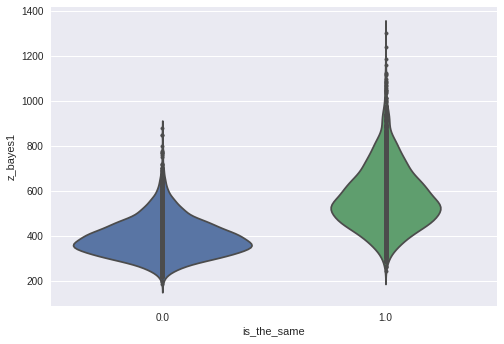

In [30]:
import seaborn as sns

sns.violinplot(data=feat_dataset, x='is_the_same', y='z_bayes1', inner="points")

In [31]:
col = [c for c in feat_dataset.columns if c[0]=='z']

X = feat_dataset[col].as_matrix()
y = feat_dataset['is_the_same'].as_matrix()

In [32]:
from sklearn.preprocessing import minmax_scale

# X = minmax_scale(X)

In [33]:
X[0]

array([ 489.40845496,  507.89032957,  495.61944283,  554.23630461])

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

In [35]:
import xgboost as xgb
params = {}
params["objective"] = "binary:logistic"
params['eval_metric'] = ['logloss', 'error']
# params["eta"] = 0.02
# params["subsample"] = 0.7
# params["min_child_weight"] = 1
# params["colsample_bytree"] = 0.7
params["max_depth"] = 4
params["seed"] = 1632

d_train = xgb.DMatrix(X_train, label=y_train)
d_valid = xgb.DMatrix(X_valid, label=y_valid)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
bst = xgb.train(params, d_train, 500, watchlist, early_stopping_rounds=50, verbose_eval=100)

[0]	train-logloss:0.574742	train-error:0.186852	valid-logloss:0.572679	valid-error:0.181667
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 50 rounds.
Stopping. Best iteration:
[24]	train-logloss:0.38602	train-error:0.176852	valid-logloss:0.398842	valid-error:0.163333



In [36]:
d_all = xgb.DMatrix(X, label=y)

xgb.cv(params, d_all, 500, nfold=10, metrics=['error'], shuffle=False, early_stopping_rounds=50, seed=42)

,test-error-mean,test-error-std,train-error-mean,train-error-std
0,0.191833,0.019328,0.184444,0.002060
1,0.191833,0.014934,0.184278,0.001875
2,0.195000,0.014720,0.183241,0.002123
3,0.192833,0.014299,0.181704,0.001441
4,0.193833,0.013603,0.180630,0.001912
5,0.192333,0.013565,0.180093,0.001698
6,0.191833,0.014131,0.179593,0.001462
7,0.192333,0.013441,0.179444,0.001737
8,0.192000,0.013433,0.178889,0.001790
9,0.191500,0.012898,0.178537,0.001419
